In [1]:
import uproot
import pandas
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import gc
from sklearn.model_selection import train_test_split

C:\Users\konst\AppData\Roaming\Python\Python36\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
central_tau_id_branches = ['againstElectronMVA6Raw', 'byCombinedIsolationDeltaBetaCorrRaw3Hits',
    'byIsolationMVArun2v1DBoldDMwLTraw', 'byIsolationMVArun2v1DBdR03oldDMwLTraw',
    'byIsolationMVArun2v1DBoldDMwLTraw2016', 'byIsolationMVArun2017v2DBoldDMwLTraw2017',
    'byIsolationMVArun2017v2DBoldDMdR0p3wLTraw2017', 'id_flags']
truth_branches = ['gen_match']
input_branches = ['pt', 'eta', 'phi', 'mass', 'decayMode', 'dxy', 'dxy_sig', 'dz', 'ip3d', 'ip3d_sig',
                  'hasSecondaryVertex', 'flightLength_r', 'flightLength_eta', 'flightLength_phi',
                  'flightLength_sig', 'leadChargedHadrCand_pt', 'leadChargedHadrCand_eta',
                  'leadChargedHadrCand_phi', 'leadChargedHadrCand_mass', 'pt_weighted_deta_strip',
                  'pt_weighted_dphi_strip', 'pt_weighted_dr_signal', 'pt_weighted_dr_iso',
                  'leadingTrackNormChi2', 'e_ratio', 'gj_angle_diff', 'n_photons', 'emFraction', 'etaAtEcalEntrance',
                  'phiAtEcalEntrance', 'has_gsf_track', 'inside_ecal_crack', 'ecal_crack_dPhi', 'ecal_crack_dEta',
                  'gsf_ele_matched', 'gsf_ele_pt', 'gsf_ele_eta', 'gsf_ele_phi', 'gsf_ele_mass', 'gsf_ele_Ee',
                  'gsf_ele_Egamma', 'gsf_ele_Pin', 'gsf_ele_Pout', 'gsf_ele_EtotOverPin', 'gsf_ele_Eecal',
                  'gsf_ele_deta', 'gsf_ele_dphi', 'gsf_ele_mvaIn_sigmaEtaEta', 'gsf_ele_mvaIn_hadEnergy',
                  'gsf_ele_mvaIn_deltaEta', 'gsf_ele_Chi2NormGSF', 'gsf_ele_GSFNumHits', 'gsf_ele_GSFTrackResol',
                  'gsf_ele_GSFTracklnPt', 'gsf_ele_Chi2NormKF', 'gsf_ele_KFNumHits',
                  'leadChargedCand_etaAtEcalEntrance', 'leadChargedCand_pt', 'leadChargedHadrCand_HoP',
                  'leadChargedHadrCand_EoP', 'tau_visMass_innerSigCone', 'has_matched_muon',
                  'muon_n_stations_with_matches_03', 'muon_n_stations_with_hits_23', 'energy_ECAL', 'energy_HCAL',
                  'leadTrack_p', 'chargedIsoPtSum', 'chargedIsoPtSumdR03', 'footprintCorrection',
                  'footprintCorrectiondR03', 'neutralIsoPtSum', 'neutralIsoPtSumWeight', 'neutralIsoPtSumWeightdR03',
                  'neutralIsoPtSumdR03', 'photonPtSumOutsideSignalCone', 'photonPtSumOutsideSignalConedR03',
                  'puCorrPtSum'
                 ]
all_branches = truth_branches + input_branches + central_tau_id_branches
match_suffixes = [ 'e', 'mu', 'tau', 'jet' ]
gen_match_ex_branches = [ 'gen_match_{}'.format(suff) for suff in match_suffixes ]

In [3]:
def ReadBranches(file_name_pattern, tree_name, branches):
    df = None
    z = None
    n = 1
    max_gen_match = 6
    for br in branches:
        arr = None
        #for gen_match in range(1, max_gen_match + 1):
        for gen_match in [1, 2, 5, 6]:
            file = uproot.open(file_name_pattern.format(gen_match))
            tree = file[tree_name]
            
            new_arr = tree[br].array()
            if arr is None:
                arr = new_arr
            else:
                arr = np.append(arr, new_arr)
        if df is None:
            df = pandas.DataFrame({br: arr})
            z = np.ones(df[br].shape)
            z *= -999
        else:
            df[br] = pandas.Series(arr, df.index)
        df[br] = np.maximum(df[br], z)

        print("branch '{}' loaded. {}/{}".format(br, n, len(branches)))
        n += 1
        gc.collect()
    return df

In [8]:
def ReadBranch(file_name_pattern, tree_name, br, df):
    arr = None
    for gen_match in [1, 2, 5, 6]:
        file = uproot.open(file_name_pattern.format(gen_match))
        tree = file[tree_name]
        #print(tree.keys())

        new_arr = tree[br].array()
        if arr is None:
            arr = new_arr
        else:
            arr = np.append(arr, new_arr)
    df[br] = pandas.Series(arr, df.index)

    print("branch '{}' loaded.".format(br))
    gc.collect()

In [9]:
ReadBranch('../../tuples/tau_5e5_{}.root', 'taus', 'id_flags', data)

branch 'id_flags' loaded.


In [10]:
data['againstMuonLoose3'] = pandas.Series(np.bitwise_and(np.right_shift(data['id_flags'], 5), 1), data.index)
data['againstMuonTight3'] = pandas.Series(np.bitwise_and(np.right_shift(data['id_flags'], 6), 1), data.index)

In [4]:
def VectorizeGenMatch(data):
    e = (data["gen_match"] == 1) | (data["gen_match"] == 3)
    data['gen_match_e'] = pandas.Series(e.astype(int), data.index)
    mu = (data["gen_match"] == 2) | (data["gen_match"] == 4)
    data['gen_match_mu'] = pandas.Series(mu.astype(int), data.index)
    tau = data["gen_match"] == 5
    data['gen_match_tau'] = pandas.Series(tau.astype(int), data.index)
    jet = data["gen_match"] == 6
    data['gen_match_jet'] = pandas.Series(jet.astype(int), data.index)

In [5]:
data = ReadBranches('../../tuples/tau_5e5_{}.root', 'taus', all_branches)

branch 'gen_match' loaded. 1/87
branch 'pt' loaded. 2/87
branch 'eta' loaded. 3/87
branch 'phi' loaded. 4/87
branch 'mass' loaded. 5/87
branch 'decayMode' loaded. 6/87
branch 'dxy' loaded. 7/87
branch 'dxy_sig' loaded. 8/87
branch 'dz' loaded. 9/87
branch 'ip3d' loaded. 10/87
branch 'ip3d_sig' loaded. 11/87
branch 'hasSecondaryVertex' loaded. 12/87
branch 'flightLength_r' loaded. 13/87
branch 'flightLength_eta' loaded. 14/87
branch 'flightLength_phi' loaded. 15/87
branch 'flightLength_sig' loaded. 16/87
branch 'leadChargedHadrCand_pt' loaded. 17/87
branch 'leadChargedHadrCand_eta' loaded. 18/87
branch 'leadChargedHadrCand_phi' loaded. 19/87
branch 'leadChargedHadrCand_mass' loaded. 20/87
branch 'pt_weighted_deta_strip' loaded. 21/87
branch 'pt_weighted_dphi_strip' loaded. 22/87
branch 'pt_weighted_dr_signal' loaded. 23/87
branch 'pt_weighted_dr_iso' loaded. 24/87
branch 'leadingTrackNormChi2' loaded. 25/87
branch 'e_ratio' loaded. 26/87
branch 'gj_angle_diff' loaded. 27/87
branch 'n_ph

In [6]:
VectorizeGenMatch(data)
data.shape

(2000000, 91)

In [11]:
#data_tj = data[((data['gen_match_tau'] == 1) | (data['gen_match_jet'] == 1)) & (data['pt'] > 20) & (data['pt'] < 100)]
data_train, data_test = train_test_split(data.sample(frac=1.), test_size=0.2)
X_train = data_train[input_branches]
Y_train = data_train[gen_match_ex_branches]
#Y_train = data_train['gen_match_tau']
input_shape = (len(input_branches), )
n_outputs = len(gen_match_ex_branches)

In [17]:
n_hidden_layers = 10
n_neurons = 1024
model_name = "{}L{}N".format(n_hidden_layers, n_neurons)
model = Sequential()
model.add(Dense(n_neurons, input_shape=input_shape, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
for n in range(n_hidden_layers):
    model.add(Dense(n_neurons, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
model.add(Dense(n_outputs))
model.add(Activation("softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"],)

In [38]:
#model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, Y_test))
cb = ModelCheckpoint("{}_0503_step2.hdf5".format(model_name), monitor="val_acc", save_best_only=True, save_weights_only=False,
                     mode="auto")
model.fit(X_train, Y_train, callbacks=[cb], validation_split=0.1, batch_size=10000, epochs=100, verbose=1,
          class_weight={0: 1, 1: 1, 2: 1, 3:1 })
#score = model.evaluate(X_test, Y_test, verbose=0)
#print("Test: score {}, accuracy {}".format(score[0], score[1]))

Train on 1440000 samples, validate on 160000 samples
Epoch 1/100
1440000/1440000 [==============================] - 42s 29us/step - loss: 0.2190 - acc: 0.9210 - val_loss: 1.1921 - val_acc: 0.5590
Epoch 2/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.2207 - acc: 0.9203 - val_loss: 0.8560 - val_acc: 0.6789
Epoch 3/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.2188 - acc: 0.9210 - val_loss: 0.8700 - val_acc: 0.6372
Epoch 4/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.2183 - acc: 0.9215 - val_loss: 0.8619 - val_acc: 0.6481
Epoch 5/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.2189 - acc: 0.9212 - val_loss: 0.7458 - val_acc: 0.7590
Epoch 6/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.2184 - acc: 0.9212 - val_loss: 0.6191 - val_acc: 0.8289
Epoch 7/100
1440000/1440000 [==============================] - 43s 30us/step - loss: 0.21

In [12]:
#model = load_model("{}.hdf5".format(model_name))
#model = load_model("T2155.hdf5")
model = load_model("10L1024N_w_100epochs.hdf5")

In [39]:
pred = model.predict(data_test[input_branches])
for n in range(len(match_suffixes)):
    data_test["deepId_{}".format(match_suffixes[n])] = pandas.Series(pred[:, n], data_test.index)
#data_test["deepId_tau"] = pandas.Series(pred[:,0], data_test.index)

In [146]:
pred

array([[0.6544525 ],
       [0.14560634],
       [0.24894914],
       ...,
       [0.6918787 ],
       [0.67491   ],
       [0.3178241 ]], dtype=float32)

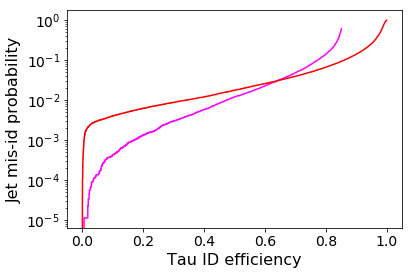

In [67]:
data_tj_test = data_test[((data_test['gen_match_tau'] == 1) | (data_test['gen_match_jet'] == 1))
                    & (data_test['pt'] > 20) & (data_test['pt'] < 100)]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(data_tj_test['gen_match_tau'],
                                                     data_tj_test['byIsolationMVArun2017v2DBoldDMwLTraw2017'])
best_guess = data_tj_test['deepId_tau']/(data_tj_test['deepId_jet'])
#best_guess = data_tj_test['deepId_tau']
fpr, tpr, thresholds = metrics.roc_curve(data_tj_test['gen_match_tau'], best_guess)
plt.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Jet mis-id probability', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_jet.pdf', bbox_inches='tight')

In [198]:
#model.save("T2155.hdf5")

C:\Users\konst\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


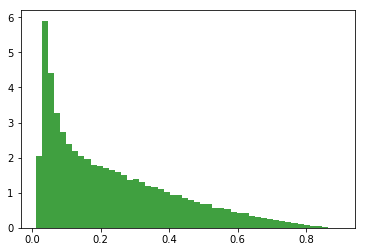

In [231]:
plt.hist(data_tj_test[data_tj_test['gen_match_jet'] == 1]['deepId_tau'], 50, normed=1, facecolor='green', alpha=0.75);

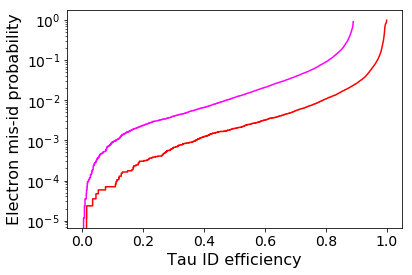

In [66]:
data_et_test = data_test[((data_test['gen_match_tau'] == 1) | (data_test['gen_match_e'] == 1))
                    & (data_test['pt'] > 20) & (data_test['pt'] < 100)]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(data_et_test['gen_match_tau'],
                                                     data_et_test['againstElectronMVA6Raw'])
best_guess = data_et_test['deepId_tau']/(data_et_test['deepId_e'])
#best_guess = data_et_test['deepId_tau']
fpr, tpr, thresholds = metrics.roc_curve(data_et_test['gen_match_tau'], best_guess)
plt.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Electron mis-id probability', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_ele.pdf', bbox_inches='tight')

C:\Users\konst\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


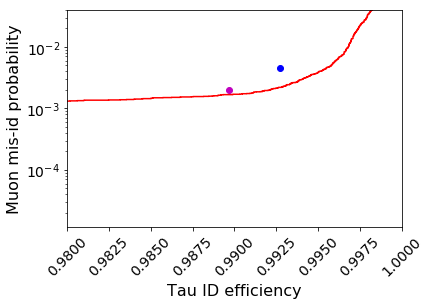

In [65]:
data_mt_test = data_test[((data_test['gen_match_tau'] == 1) | (data_test['gen_match_mu'] == 1))
                    & (data_test['pt'] > 20) & (data_test['pt'] < 100)]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(data_mt_test['gen_match_tau'],
                                                     data_mt_test['againstMuonLoose3'])
fpr_ref_2, tpr_ref_2, thresholds_ref_2 = metrics.roc_curve(data_mt_test['gen_match_tau'],
                                                     data_mt_test['againstMuonTight3'])

best_guess = data_mt_test['deepId_tau']/data_mt_test['deepId_mu']
#best_guess = data_et_test['deepId_tau']
fpr, tpr, thresholds = metrics.roc_curve(data_mt_test['gen_match_tau'], best_guess)
plt.semilogy(tpr_ref[1:2], fpr_ref[1:2], 'bo', tpr_ref_2[1:2], fpr_ref_2[1:2], 'mo', tpr, fpr, 'red')
plt.ylim([0., 0.04])
plt.xlim([.98, 1])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Muon mis-id probability', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.savefig('tau_vs_mu.pdf', bbox_inches='tight')

In [49]:
#model.save('10L1024N_w_100epochs.hdf5')
#model.save('10L1024N_w_500epochs.hdf5')
#model.save('10L1024N_w_600epochs.hdf5')
model.save('10L1024N_200epochs.hdf5')

In [48]:
model_name

'10L1024N'

In [292]:
fpr_ref[1:2]

array([0.00459036])

In [50]:
import pickle

In [51]:
data_train.to_pickle('data_train.pkl', 'bz2')

In [52]:
data_test.to_pickle('data_test.pkl', 'bz2')